In [1]:
import kagglehub
import pandas as pd
import os
import matplotlib.pyplot as plt

### Download data from kaggle

In [2]:
path = kagglehub.dataset_download("jeanmidev/smart-meters-in-london")
TARGET_BLOCKS_DATADIR = os.path.join(path,'hhblock_dataset/hhblock_dataset')
blocks_csv_files = [
        os.path.join(TARGET_BLOCKS_DATADIR, csv_path)
        for csv_path in filter(
            lambda path:
            path.endswith('.csv'),
            os.listdir(TARGET_BLOCKS_DATADIR))
    ]

### Choose the block name and print it

In [3]:
idx = 0
path_specified=f"{TARGET_BLOCKS_DATADIR}/block_{idx}.csv"
block = pd.read_csv(path_specified, encoding='latin', parse_dates=['day'], date_format='%Y-%m-%d')
block.head(5)

,LCLid,day,hh_0,hh_1,hh_2,hh_3,hh_4,hh_5,hh_6,hh_7,...,hh_38,hh_39,hh_40,hh_41,hh_42,hh_43,hh_44,hh_45,hh_46,hh_47
0,MAC000002,2012-10-13,0.263,0.269,0.275,0.256,0.211,0.136,0.161,0.119,...,0.918,0.278,0.267,0.239,0.230,0.233,0.235,0.188,0.259,0.250
1,MAC000002,2012-10-14,0.262,0.166,0.226,0.088,0.126,0.082,0.123,0.083,...,1.075,0.956,0.821,0.745,0.712,0.511,0.231,0.210,0.278,0.159
2,MAC000002,2012-10-15,0.192,0.097,0.141,0.083,0.132,0.070,0.130,0.074,...,1.164,0.249,0.225,0.258,0.260,0.334,0.299,0.236,0.241,0.237
3,MAC000002,2012-10-16,0.237,0.237,0.193,0.118,0.098,0.107,0.094,0.109,...,0.966,0.172,0.192,0.228,0.203,0.211,0.188,0.213,0.157,0.202
4,MAC000002,2012-10-17,0.157,0.211,0.155,0.169,0.101,0.117,0.084,0.118,...,0.223,0.075,0.230,0.208,0.265,0.377,0.327,0.277,0.288,0.256


### This function is used to fill the gaps between days (missing days)

In [4]:
def convert_consumer_to_standard_form(consumer_data, consumer_id, verbose=False):
  start_date = consumer_data['day'].min()
  end_date = consumer_data['day'].max()
  standrad_df = pd.DataFrame()
  standrad_df['day'] = pd.date_range(start=start_date, end=end_date, freq='1D')
  standard_df  = standrad_df.merge(consumer_data, on=['day'], how='left')
  return standard_df

### This function used to convert data to time series data by frequency 30 min (48 read by day)

In [5]:
def convert_standard_form_to_expand_time_series(standard_df, consumer_id,  verbose=False):
  expand_df = pd.melt(standard_df, id_vars=['day','LCLid'],value_name='energy_consumption',var_name='offset')
  expand_df['offset'] = expand_df['offset'].str.replace('hh_','').astype(int)
  expand_df = expand_df.sort_values(by=['day','offset']).reset_index(drop=True)
  expand_df['frequency'] = '30min'
  expand_df['serie_length'] = len(expand_df)
  expand_df['timestamp'] = pd.date_range(start=standard_df['day'].min(), freq='30min', periods=len(expand_df))
  expand_df = expand_df.drop(columns=['day','offset'])
  expand_df = expand_df[['LCLid','timestamp','energy_consumption','frequency','serie_length']]
  return expand_df

In [6]:
block

,LCLid,day,hh_0,hh_1,hh_2,hh_3,hh_4,hh_5,hh_6,hh_7,...,hh_38,hh_39,hh_40,hh_41,hh_42,hh_43,hh_44,hh_45,hh_46,hh_47
0,MAC000002,2012-10-13,0.263,0.269,0.275,0.256,0.211,0.136,0.161,0.119,...,0.918,0.278,0.267,0.239,0.230,0.233,0.235,0.188,0.259,0.250
1,MAC000002,2012-10-14,0.262,0.166,0.226,0.088,0.126,0.082,0.123,0.083,...,1.075,0.956,0.821,0.745,0.712,0.511,0.231,0.210,0.278,0.159
2,MAC000002,2012-10-15,0.192,0.097,0.141,0.083,0.132,0.070,0.130,0.074,...,1.164,0.249,0.225,0.258,0.260,0.334,0.299,0.236,0.241,0.237
3,MAC000002,2012-10-16,0.237,0.237,0.193,0.118,0.098,0.107,0.094,0.109,...,0.966,0.172,0.192,0.228,0.203,0.211,0.188,0.213,0.157,0.202
4,MAC000002,2012-10-17,0.157,0.211,0.155,0.169,0.101,0.117,0.084,0.118,...,0.223,0.075,0.230,0.208,0.265,0.377,0.327,0.277,0.288,0.256
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25281,MAC005492,2014-02-23,0.165,0.206,0.149,0.101,0.115,0.120,0.102,0.105,...,0.296,0.750,0.315,0.326,0.293,0.287,0.213,0.287,0.245,0.222
25282,MAC005492,2014-02-24,0.219,0.236,0.288,0.219,0.165,0.086,0.111,0.095,...,0.303,0.378,0.253,0.193,0.212,0.193,0.192,0.297,0.168,0.170
25283,MAC005492,2014-02-25,0.194,0.185,0.150,0.095,0.081,0.082,0.081,0.112,...,0.545,0.233,0.245,0.194,0.215,0.201,0.241,0.162,0.157,0.167
25284,MAC005492,2014-02-26,0.205,0.183,0.186,0.165,0.194,0.114,0.080,0.090,...,0.298,0.224,0.239,0.242,0.237,0.246,0.333,0.202,0.232,0.203


In [7]:
result = block.groupby('LCLid').apply(lambda group: convert_consumer_to_standard_form(group, group.name)).reset_index(drop=True)
result

<ipython-input-7-35de716bdf25>:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  result = block.groupby('LCLid').apply(lambda group: convert_consumer_to_standard_form(group, group.name)).reset_index(drop=True)


,day,LCLid,hh_0,hh_1,hh_2,hh_3,hh_4,hh_5,hh_6,hh_7,...,hh_38,hh_39,hh_40,hh_41,hh_42,hh_43,hh_44,hh_45,hh_46,hh_47
0,2012-10-13,MAC000002,0.263,0.269,0.275,0.256,0.211,0.136,0.161,0.119,...,0.918,0.278,0.267,0.239,0.230,0.233,0.235,0.188,0.259,0.250
1,2012-10-14,MAC000002,0.262,0.166,0.226,0.088,0.126,0.082,0.123,0.083,...,1.075,0.956,0.821,0.745,0.712,0.511,0.231,0.210,0.278,0.159
2,2012-10-15,MAC000002,0.192,0.097,0.141,0.083,0.132,0.070,0.130,0.074,...,1.164,0.249,0.225,0.258,0.260,0.334,0.299,0.236,0.241,0.237
3,2012-10-16,MAC000002,0.237,0.237,0.193,0.118,0.098,0.107,0.094,0.109,...,0.966,0.172,0.192,0.228,0.203,0.211,0.188,0.213,0.157,0.202
4,2012-10-17,MAC000002,0.157,0.211,0.155,0.169,0.101,0.117,0.084,0.118,...,0.223,0.075,0.230,0.208,0.265,0.377,0.327,0.277,0.288,0.256
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25605,2014-02-23,MAC005492,0.165,0.206,0.149,0.101,0.115,0.120,0.102,0.105,...,0.296,0.750,0.315,0.326,0.293,0.287,0.213,0.287,0.245,0.222
25606,2014-02-24,MAC005492,0.219,0.236,0.288,0.219,0.165,0.086,0.111,0.095,...,0.303,0.378,0.253,0.193,0.212,0.193,0.192,0.297,0.168,0.170
25607,2014-02-25,MAC005492,0.194,0.185,0.150,0.095,0.081,0.082,0.081,0.112,...,0.545,0.233,0.245,0.194,0.215,0.201,0.241,0.162,0.157,0.167
25608,2014-02-26,MAC005492,0.205,0.183,0.186,0.165,0.194,0.114,0.080,0.090,...,0.298,0.224,0.239,0.242,0.237,0.246,0.333,0.202,0.232,0.203


In [8]:
expand_form = result.groupby('LCLid').apply(lambda group: convert_standard_form_to_expand_time_series(group, group.name)).reset_index(drop=True).drop_duplicates()
expand_form

<ipython-input-8-c6c5c428ad93>:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  expand_form = result.groupby('LCLid').apply(lambda group: convert_standard_form_to_expand_time_series(group, group.name)).reset_index(drop=True).drop_duplicates()


,LCLid,timestamp,energy_consumption,frequency,serie_length
0,MAC000002,2012-10-13 00:00:00,0.263,30min,23904
1,MAC000002,2012-10-13 00:30:00,0.269,30min,23904
2,MAC000002,2012-10-13 01:00:00,0.275,30min,23904
3,MAC000002,2012-10-13 01:30:00,0.256,30min,23904
4,MAC000002,2012-10-13 02:00:00,0.211,30min,23904
...,...,...,...,...,...
1213723,MAC005492,2013-10-18 21:30:00,0.250,30min,26352
1213724,MAC005492,2013-10-18 22:00:00,0.182,30min,26352
1213725,MAC005492,2013-10-18 22:30:00,0.122,30min,26352
1213726,MAC005492,2013-10-18 23:00:00,0.140,30min,26352


In [9]:
expand_form["energy_consumption"].isna().sum()

np.int64(50)

 - use specific LCLid (consumer) and visualize its reads with time (TimeSeries Analysis)
 - interplolate (impute) the NAN values in the Energy Consumption col


In [10]:
ts_df = expand_form[expand_form.LCLid=="MAC000002"].set_index("timestamp")
ts_df['energy_consumption'] = ts_df['energy_consumption'].interpolate(method='polynomial',order=3)

In [11]:
ts_df

,LCLid,energy_consumption,frequency,serie_length
timestamp,,,,
2012-10-13 00:00:00,MAC000002,0.263,30min,23904
2012-10-13 00:30:00,MAC000002,0.269,30min,23904
2012-10-13 01:00:00,MAC000002,0.275,30min,23904
2012-10-13 01:30:00,MAC000002,0.256,30min,23904
2012-10-13 02:00:00,MAC000002,0.211,30min,23904
...,...,...,...,...
2014-02-22 21:30:00,MAC000002,0.483,30min,23904
2014-02-22 22:00:00,MAC000002,0.416,30min,23904
2014-02-22 22:30:00,MAC000002,1.350,30min,23904


In [12]:
ts_df["energy_consumption"].isna().sum()

np.int64(0)

### Add some properities to use in visualizations and analysis


In [13]:
ts_df["weekday_name"] = ts_df.index.day_name()
ts_df["weekday"] = ts_df.index.weekday
ts_df["week"] = ts_df.index.isocalendar().week
ts_df["day"] = ts_df.index.day
ts_df["hour"] = ts_df.index.hour
ts_df["date"] = ts_df.index.date
ts_df["month"] = ts_df.index.month
ts_df["month_name"] = ts_df.index.month_name()
ts_df["year"] = ts_df.index.year

In [14]:
ts_df['month_name'] = pd.Categorical(ts_df['month_name'], categories=["January", "February", "March", "April", "May", "June", "July", "August", "September", "October", "November", "December"], ordered=True)
ts_df['weekday_name'] = pd.Categorical(ts_df['weekday_name'], categories=["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"], ordered=True)

In [15]:
ts_df

,LCLid,energy_consumption,frequency,serie_length,weekday_name,weekday,week,day,hour,date,month,month_name,year
timestamp,,,,,,,,,,,,,
2012-10-13 00:00:00,MAC000002,0.263,30min,23904,Saturday,5,41,13,0,2012-10-13,10,October,2012
2012-10-13 00:30:00,MAC000002,0.269,30min,23904,Saturday,5,41,13,0,2012-10-13,10,October,2012
2012-10-13 01:00:00,MAC000002,0.275,30min,23904,Saturday,5,41,13,1,2012-10-13,10,October,2012
2012-10-13 01:30:00,MAC000002,0.256,30min,23904,Saturday,5,41,13,1,2012-10-13,10,October,2012
2012-10-13 02:00:00,MAC000002,0.211,30min,23904,Saturday,5,41,13,2,2012-10-13,10,October,2012
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2014-02-22 21:30:00,MAC000002,0.483,30min,23904,Saturday,5,8,22,21,2014-02-22,2,February,2014
2014-02-22 22:00:00,MAC000002,0.416,30min,23904,Saturday,5,8,22,22,2014-02-22,2,February,2014
2014-02-22 22:30:00,MAC000002,1.350,30min,23904,Saturday,5,8,22,22,2014-02-22,2,February,2014


### Plot line, seasonal and heatmap plots with insights

## Line

**Insights** : Energy consumption began to be recorded in this block with consumer (MAC000002) in October 2012, and the times of highest consumption are the end of the year (November) and the beginning of the year (January and February).

- Reduce Noise and focus on bigger picture

<ipython-input-16-e6eea895e283>:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  plot_df = group.groupby('month_name')['energy_consumption'].mean()
<ipython-input-16-e6eea895e283>:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  plot_df = group.groupby('month_name')['energy_consumption'].mean()
<ipython-input-16-e6eea895e283>:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  plot_df = group.groupby('month_name')['energy_c

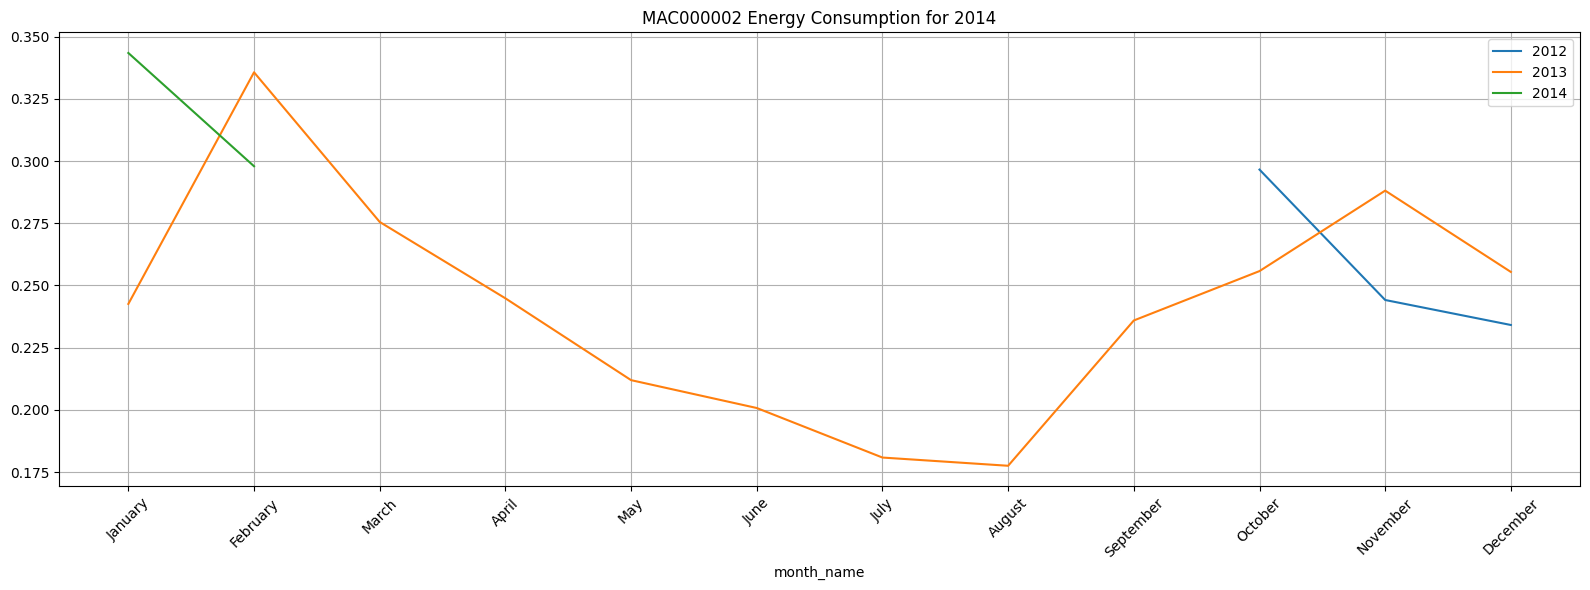

In [16]:
fig, ax = plt.subplots(1, 1, figsize=(16, 6))
for year, group in ts_df.groupby('year'):
  ax.set_title('MAC000002 Energy Consumption for {}'.format(year))
  plot_df = group.groupby('month_name')['energy_consumption'].mean()
  plot_df.plot(ax=ax, label=year)
  ax.set_xticks(range(len(plot_df)), plot_df.index, rotation=45)
  ax.grid(True)
  ax.legend()
  fig.tight_layout()

### when we rolling the data using window 48 * 30 :
- In 2013, energy use peaked in March, likely due to heating, then dropped - through the year.

- Data for 2012 and 2014 is limited to Jan–Feb, so patterns aren't clear.

- The 30-day rolling average smooths the curve, making yearly trends easier to compare.

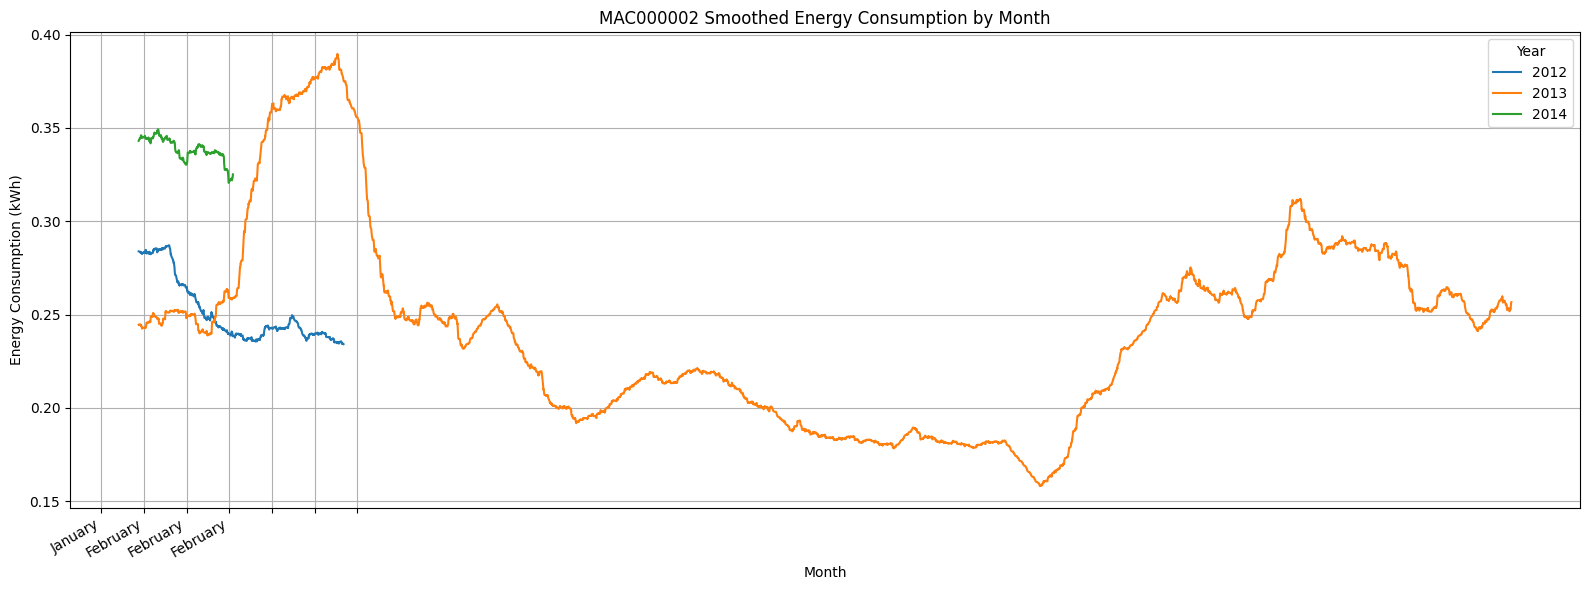

In [27]:
fig, ax = plt.subplots(1, 1, figsize=(16, 6))

for year, group in ts_df.groupby('year'):
    smoothed = group['energy_consumption'].rolling(48 * 30).mean().reset_index()
    smoothed['month_name'] = smoothed['timestamp'].dt.month_name()

    smoothed.plot(
        x='month_name',
        y='energy_consumption',
        label=year,
        ax=ax
    )

ax.set_title('MAC000002 Smoothed Energy Consumption by Month')
ax.set_xlabel('Month')
ax.set_ylabel('Energy Consumption (kWh)')
ax.grid(True)
ax.legend(title='Year')

fig.autofmt_xdate()
fig.tight_layout()
plt.show()

### Seasonal plots

In [30]:
plot_df = ts_df.groupby(["year", "month_name"])[['energy_consumption']].mean()
plot_df['energy_consumption'] = plot_df['energy_consumption'] / plot_df['energy_consumption'].max()
plot_df

<ipython-input-30-b603a66b36fc>:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  plot_df = ts_df.groupby(["year", "month_name"])[['energy_consumption']].mean()


energy_consumption
year month_name                    
2012 January                    NaN
     February                   NaN
     March                      NaN
     April                      NaN
     May                        NaN
     June                       NaN
     July                       NaN
     August                     NaN
     September                  NaN
     October               0.863571
     November              0.711051
     December              0.681809
2013 January               0.706461
     February              0.977395
     March                 0.802336
     April                 0.713010
     May                   0.617295
     June                  0.584703
     July                  0.526759
     August                0.517140
     September             0.687105
     October               0.744867
     November              0.838984
     December              0.743851
2014 January               1.000000
     February              0.867506
     March                      NaN
     April                      NaN
     May                        NaN
     June                       NaN
     July                       NaN
     August                     NaN
     September                  NaN
     October                    NaN
     November                   NaN
     December                   NaN

- There is a Seasonal Trend higher energy usage in the winter months (Jan , Feb) and lower usage in the summer months (Jul , Aug).
- This might be due to heating in winter and less energy needed in summer.

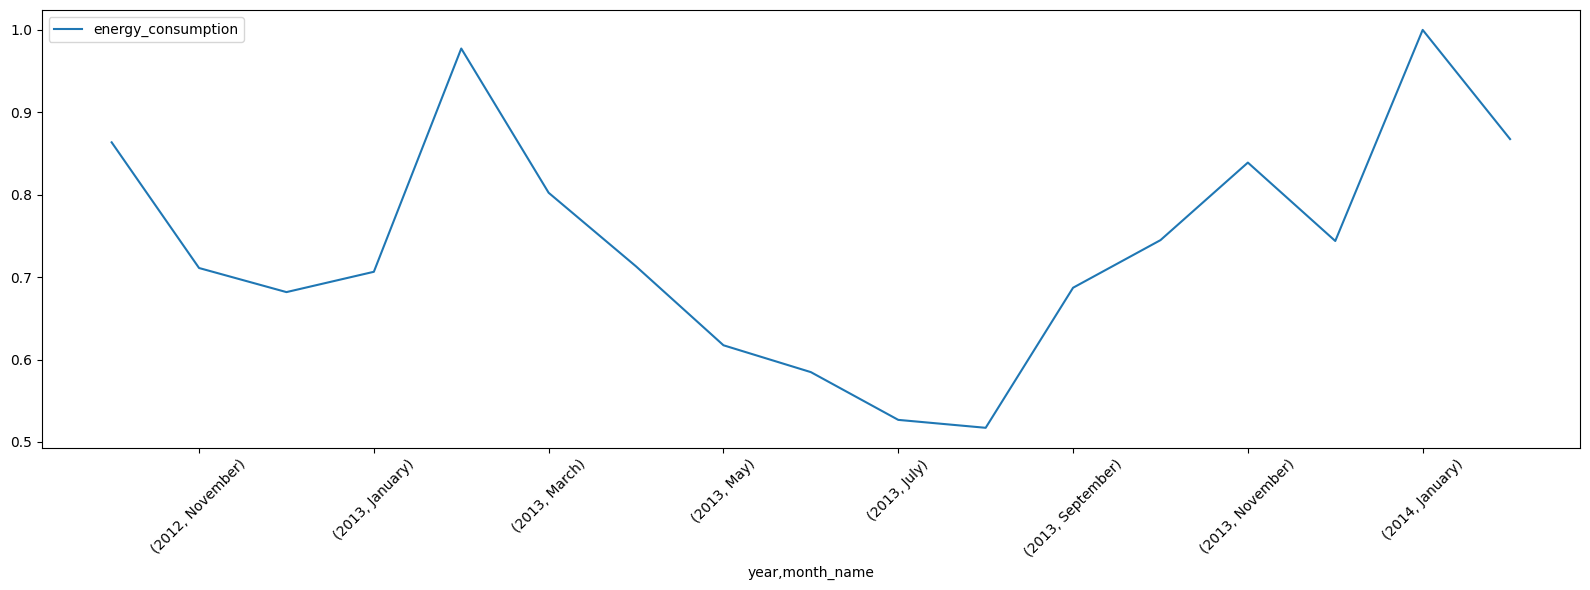

In [33]:
fig, ax = plt.subplots(1, 1, figsize=(16, 6))
plot_df.plot(ax=ax)
plt.xticks(rotation=45)
fig.tight_layout()
plt.show()

## To Analyze the change of energy consumption per hour

In [39]:
plot_df = ts_df.groupby(["day", "hour"])[['energy_consumption']].mean()
plot_df['energy_consumption'] = plot_df['energy_consumption'] / plot_df['energy_consumption'].max()

- Energy use is lowest late at night (1–5 AM) and peaks in the evening (7–9 PM).
- There's a small rise in the morning (6–8 AM) as people start their day, then it dips around noon.
- The pattern repeats daily, showing a clear routine in energy consumption.

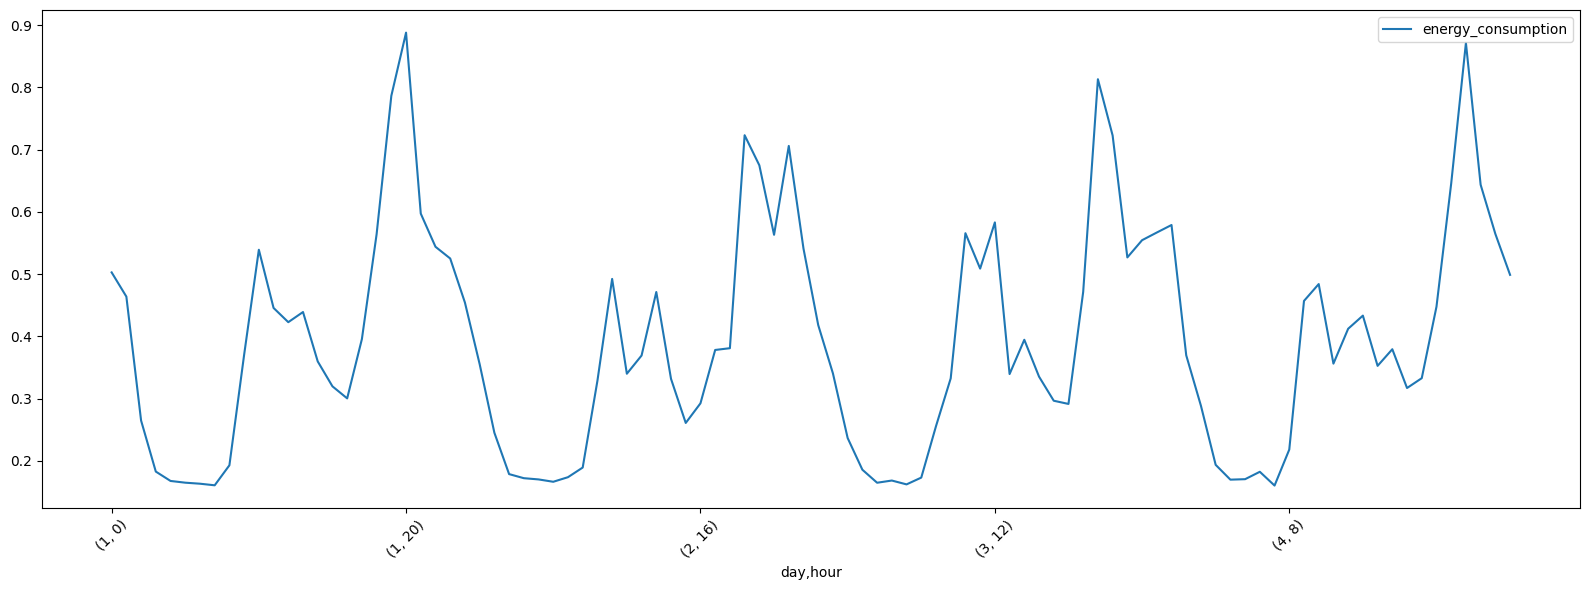

In [40]:
fig, ax = plt.subplots(1,1, figsize=(16, 6))
plot_df.iloc[:96].plot(ax=ax)
plt.xticks(rotation=45)
fig.tight_layout()
plt.show()

### Seasonal Box Plot

In [41]:
plot_df =  ts_df.groupby(["date","weekday_name", "hour"])["energy_consumption"].mean().sort_index().dropna().reset_index()

<ipython-input-41-12e4e1b68b71>:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  plot_df =  ts_df.groupby(["date","weekday_name", "hour"])["energy_consumption"].mean().sort_index().dropna().reset_index()


In [42]:
plot_df.query('(weekday_name == "Monday") & (hour == 0)')

,date,weekday_name,hour,energy_consumption
48,2012-10-15,Monday,0,0.1445
216,2012-10-22,Monday,0,0.4160
384,2012-10-29,Monday,0,0.4045
552,2012-11-05,Monday,0,0.1770
720,2012-11-12,Monday,0,0.2600
...,...,...,...,...
11136,2014-01-20,Monday,0,0.3970
11304,2014-01-27,Monday,0,0.4965
11472,2014-02-03,Monday,0,0.5205
11640,2014-02-10,Monday,0,0.4230


### In each day i noticed that
- Energy use is lowest late at night (1–5 AM) and peaks in the evening (7–9 PM).
- There's a small rise in the morning (6–8 AM) as people start their day, then it dips around noon.
- The pattern repeats daily, showing a clear routine in energy consumption.

<ipython-input-44-29e1572bf13e>:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for weekday, group in plot_df.groupby('weekday_name'):


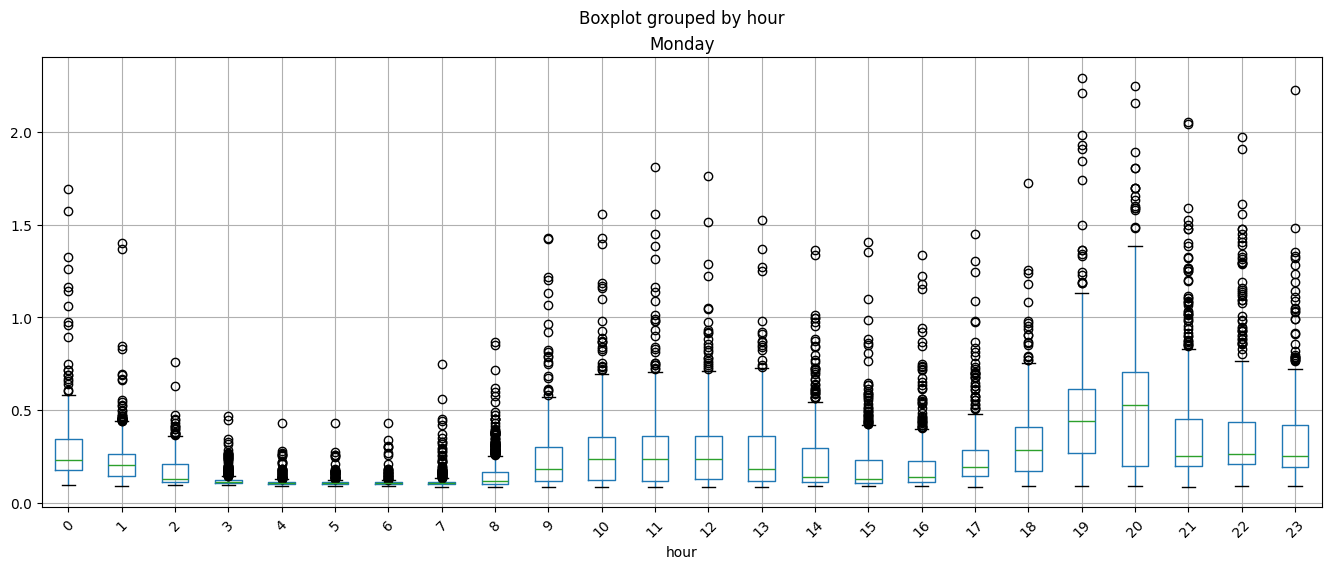

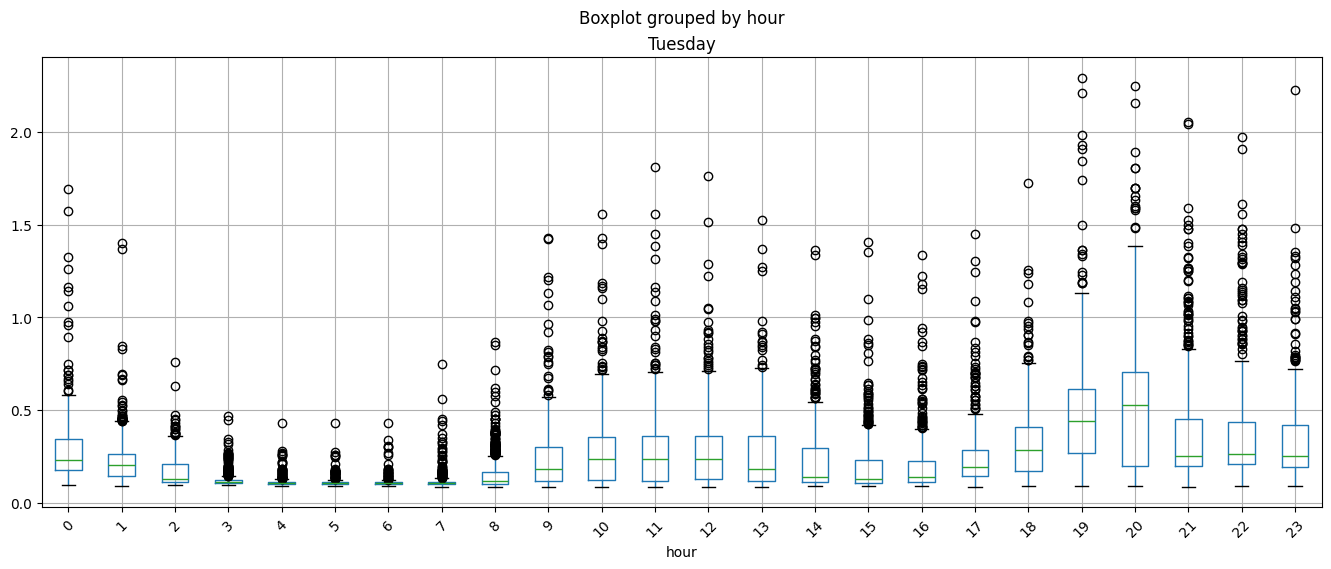

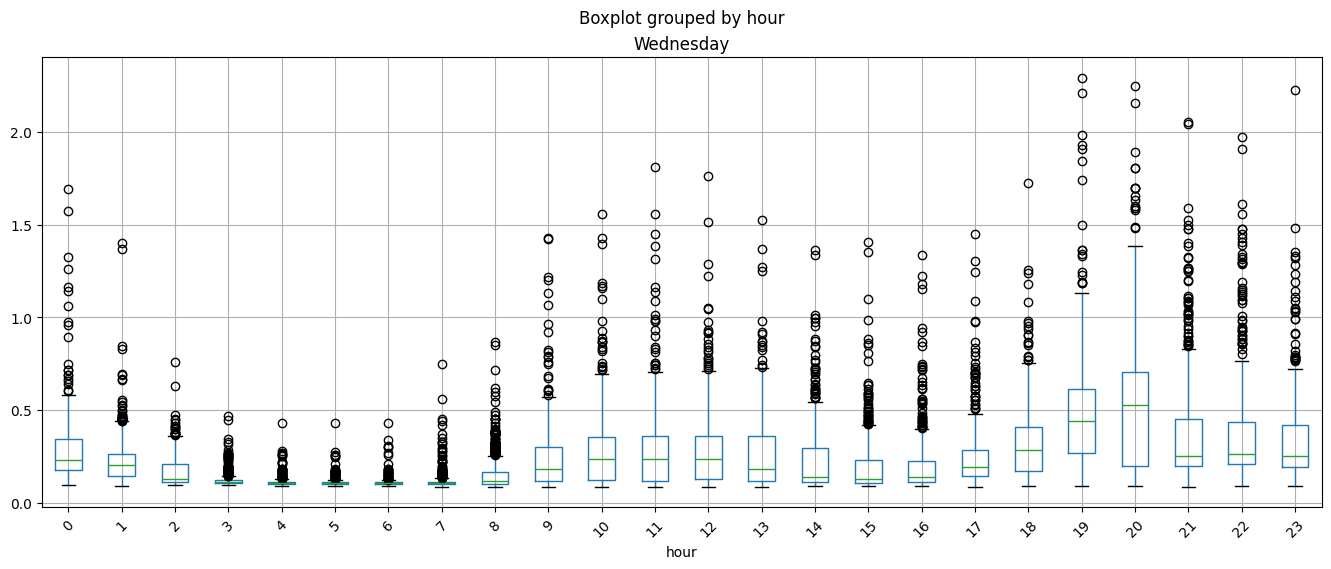

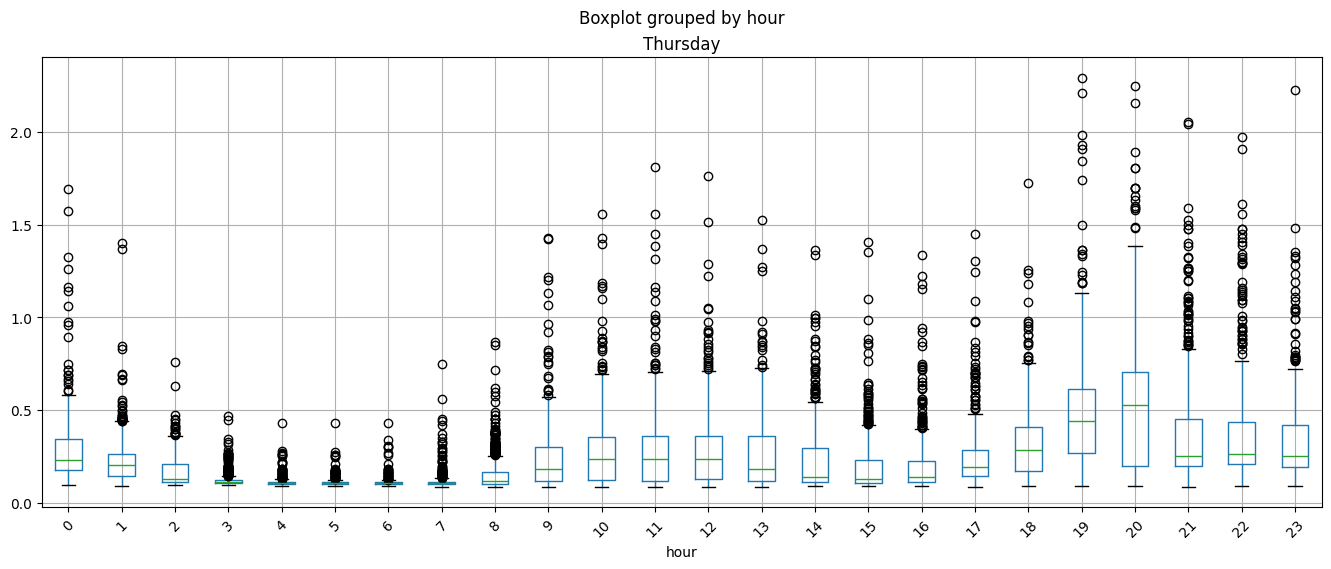

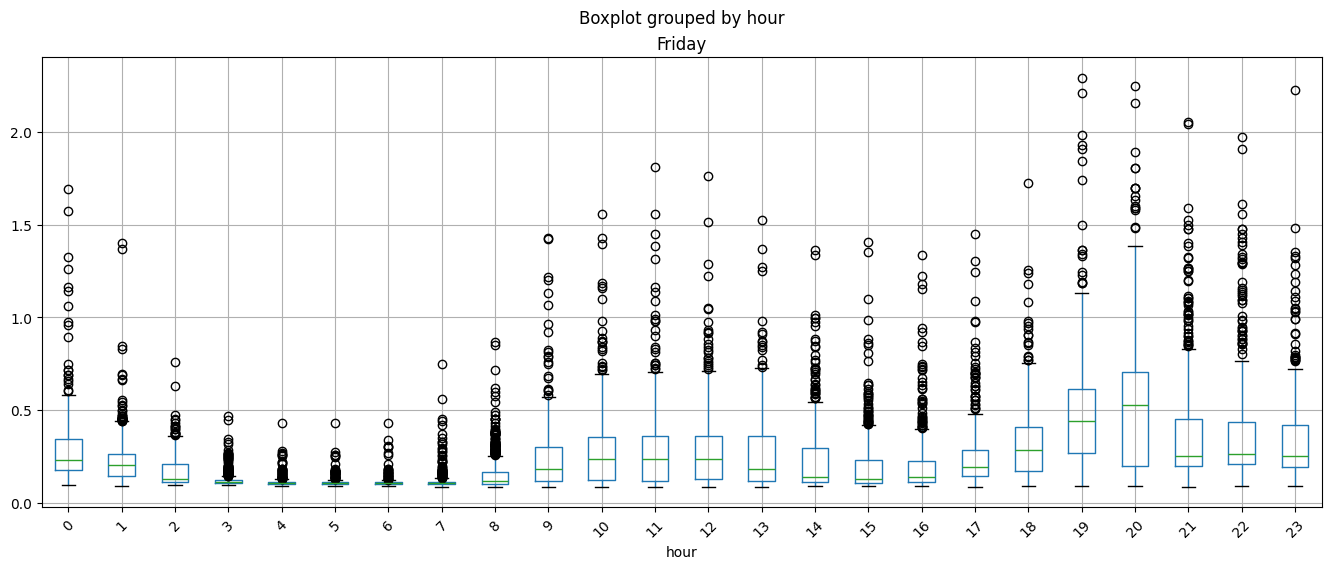

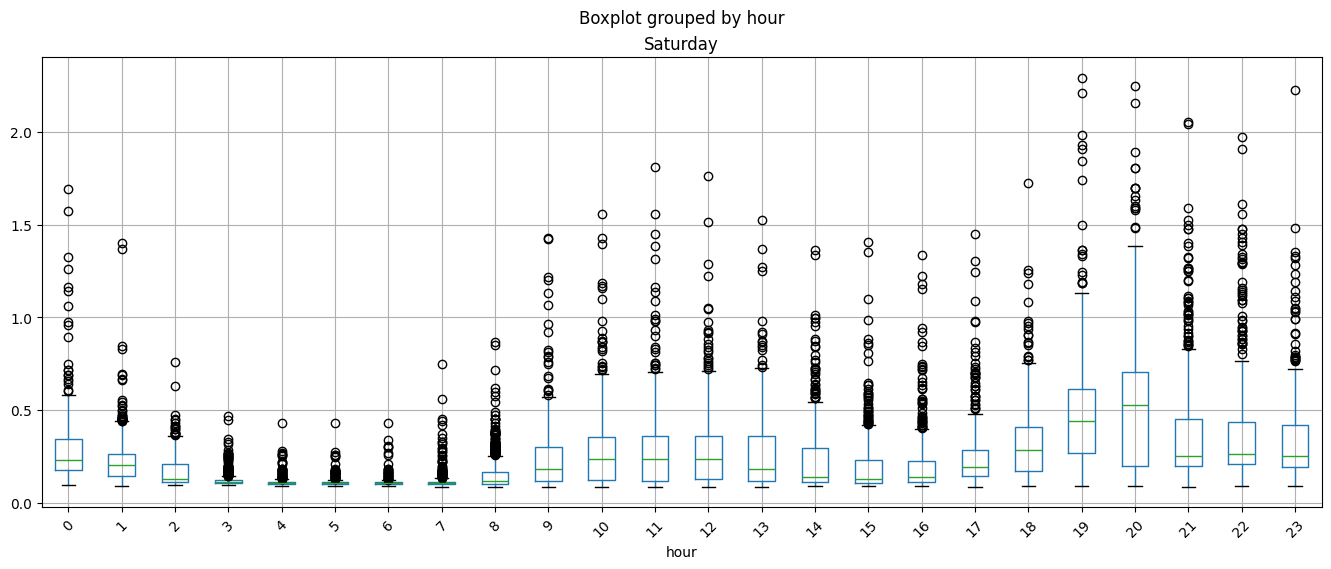

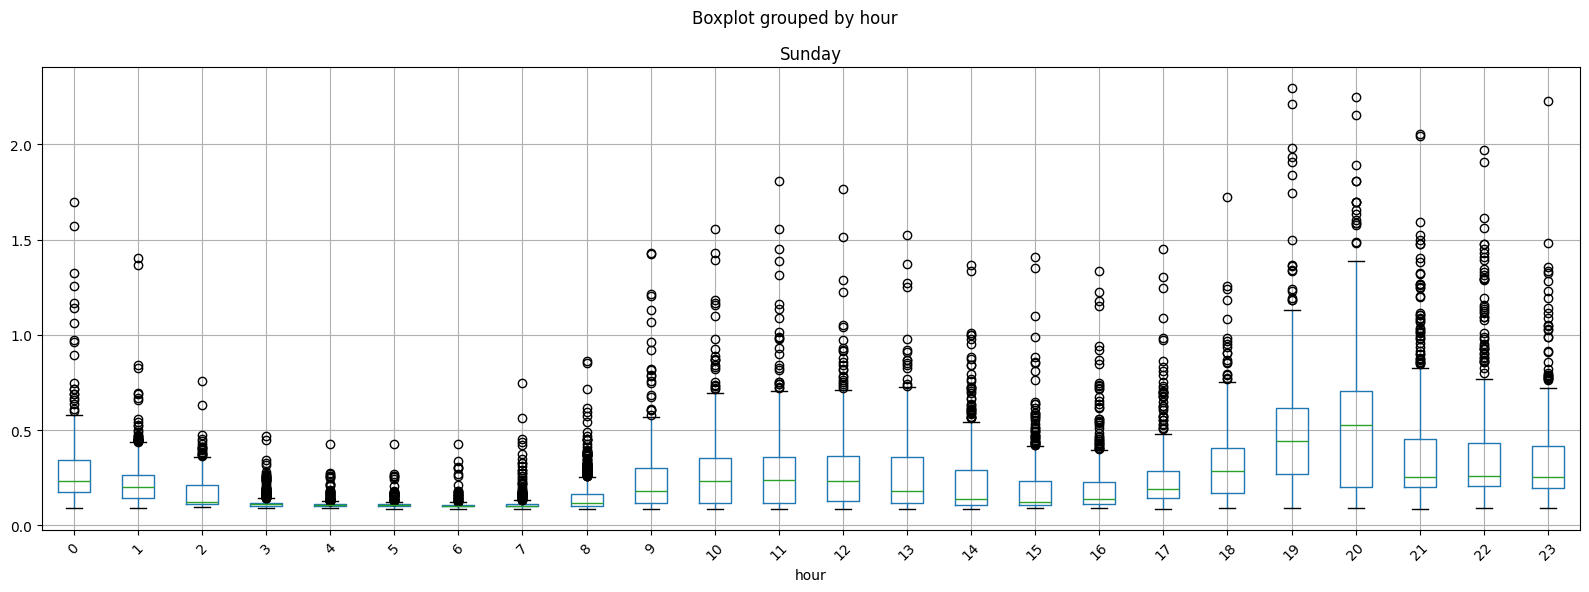

In [44]:
for weekday, group in plot_df.groupby('weekday_name'):
  fig, ax=  plt.subplots(1,1, figsize=(16, 6))
  plot_df.boxplot(column='energy_consumption', by='hour',ax=ax)
  ax.set_title(weekday)
  plt.xticks(rotation=45)
fig.tight_layout()

### Calendar HeatMap

In [45]:
energy_plot_df = pd.pivot_table(ts_df, index="weekday_name", values='energy_consumption', columns="hour", aggfunc="mean")

<ipython-input-45-7aa874fa4f44>:1: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  energy_plot_df = pd.pivot_table(ts_df, index="weekday_name", values='energy_consumption', columns="hour", aggfunc="mean")


### Red parts in the heat map are the parts (hours 19 , 20 ) 7pm , 8pm  that have alot of energy consumption in each day and in Tuesdays there are more hours of high energy consumption


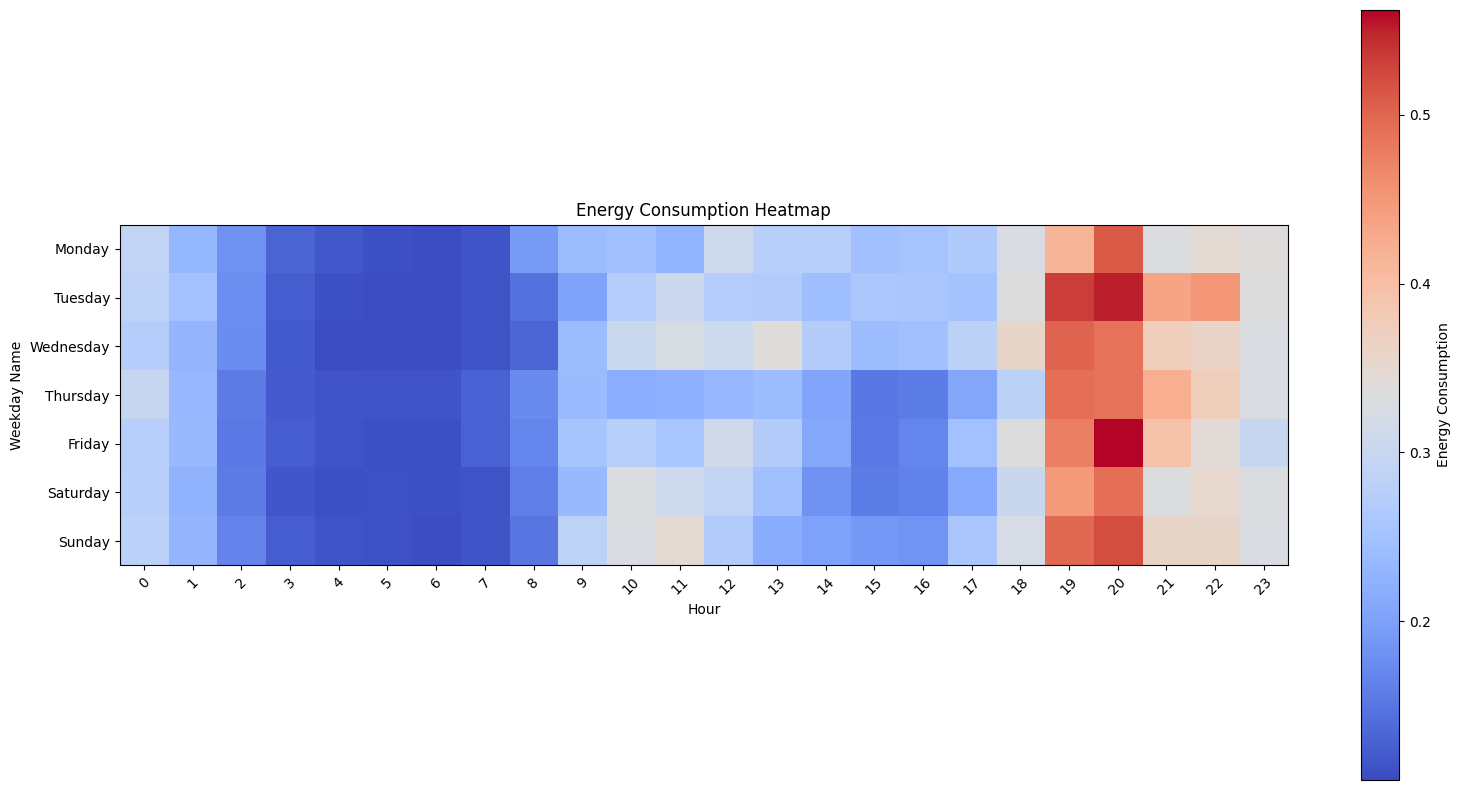

In [46]:
fig, axs = plt.subplots(1, 1, figsize=(16, 8))
img = axs.imshow(energy_plot_df, cmap='coolwarm', interpolation='nearest')
fig.colorbar(img, label='Energy Consumption')
axs.set_xticks(range(len(energy_plot_df.columns)), energy_plot_df.columns, rotation=45)
axs.set_yticks(range(len(energy_plot_df.index)), energy_plot_df.index)
axs.set_xlabel("Hour")
axs.set_ylabel("Weekday Name")
axs.set_title("Energy Consumption Heatmap")

fig.tight_layout()


## Autocorrelation and Partial Autocorrelation plots

In [47]:
target_ts = ts_df.groupby(['year','month','day','hour']).energy_consumption.mean()

1. ACF:
- The first bar is very high : this means energy usage now is very similar to 1 hour ago (the same hour i think).

- Some smaller bars appear regularly : this tells us energy usage repeats in a daily pattern.

2. PACF:
- Only the first bar is high  this means energy usage is mainly affected by just the previous hour.

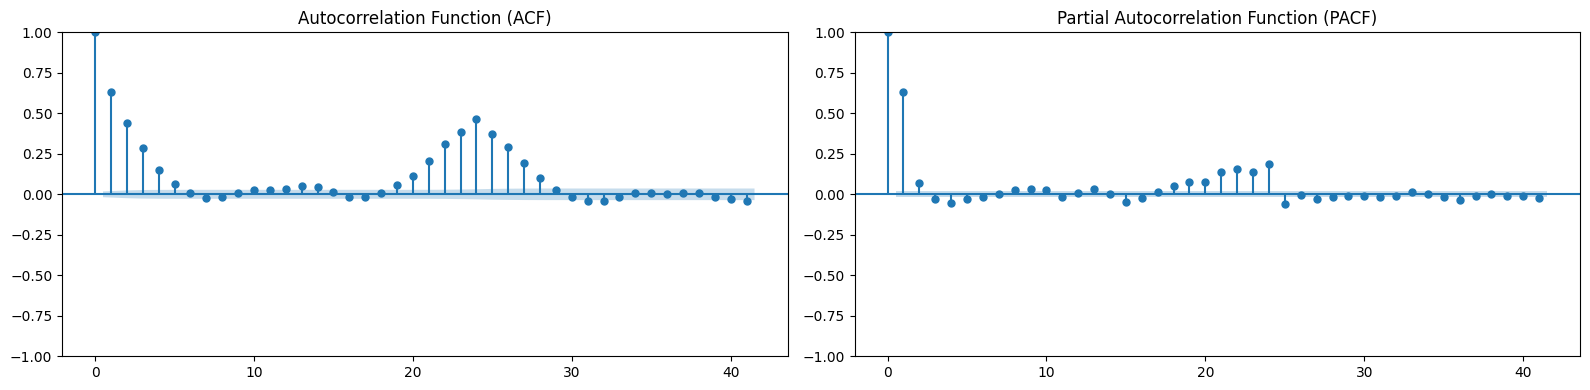

In [48]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig, axes = plt.subplots(1, 2, figsize=(16, 4))

plot_acf(target_ts, ax=axes[0])
axes[0].set_title('Autocorrelation Function (ACF)')

plot_pacf(target_ts, ax=axes[1])
axes[1].set_title('Partial Autocorrelation Function (PACF)')

plt.tight_layout()
plt.show()


## Time Series Decomposition

Extract the trend using moving average detrendibg technique (alot of noise )

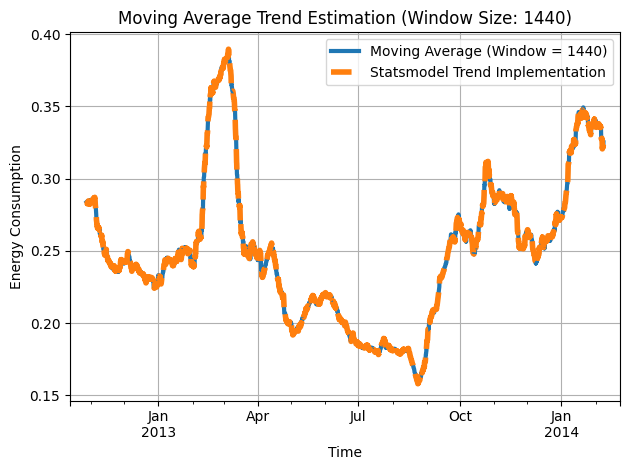

In [59]:
def plot_moving_average(ts_df, window_size):
    from statsmodels.tsa.seasonal import seasonal_decompose

    result = seasonal_decompose(ts_df['energy_consumption'], model='additive', period=window_size)

    ts_df['moving_average'] = ts_df['energy_consumption'].rolling(window=window_size, center=True).mean()

    fig, ax = plt.subplots(1, 1)
    ts_df['moving_average'].plot(ax=ax, label=f'Moving Average (Window = {window_size})', linewidth='3')
    result.trend.dropna().plot(ax=ax, label='Statsmodel Trend Implementation', linestyle='--', linewidth='4')

    ax.set_xlabel('Time')
    ax.set_ylabel('Energy Consumption')
    ax.set_title(f'Moving Average Trend Estimation (Window Size: {window_size})')
    ax.legend()
    ax.grid(True)
    fig.tight_layout()
    plt.show()

plot_moving_average(ts_df, window_size=48*30)


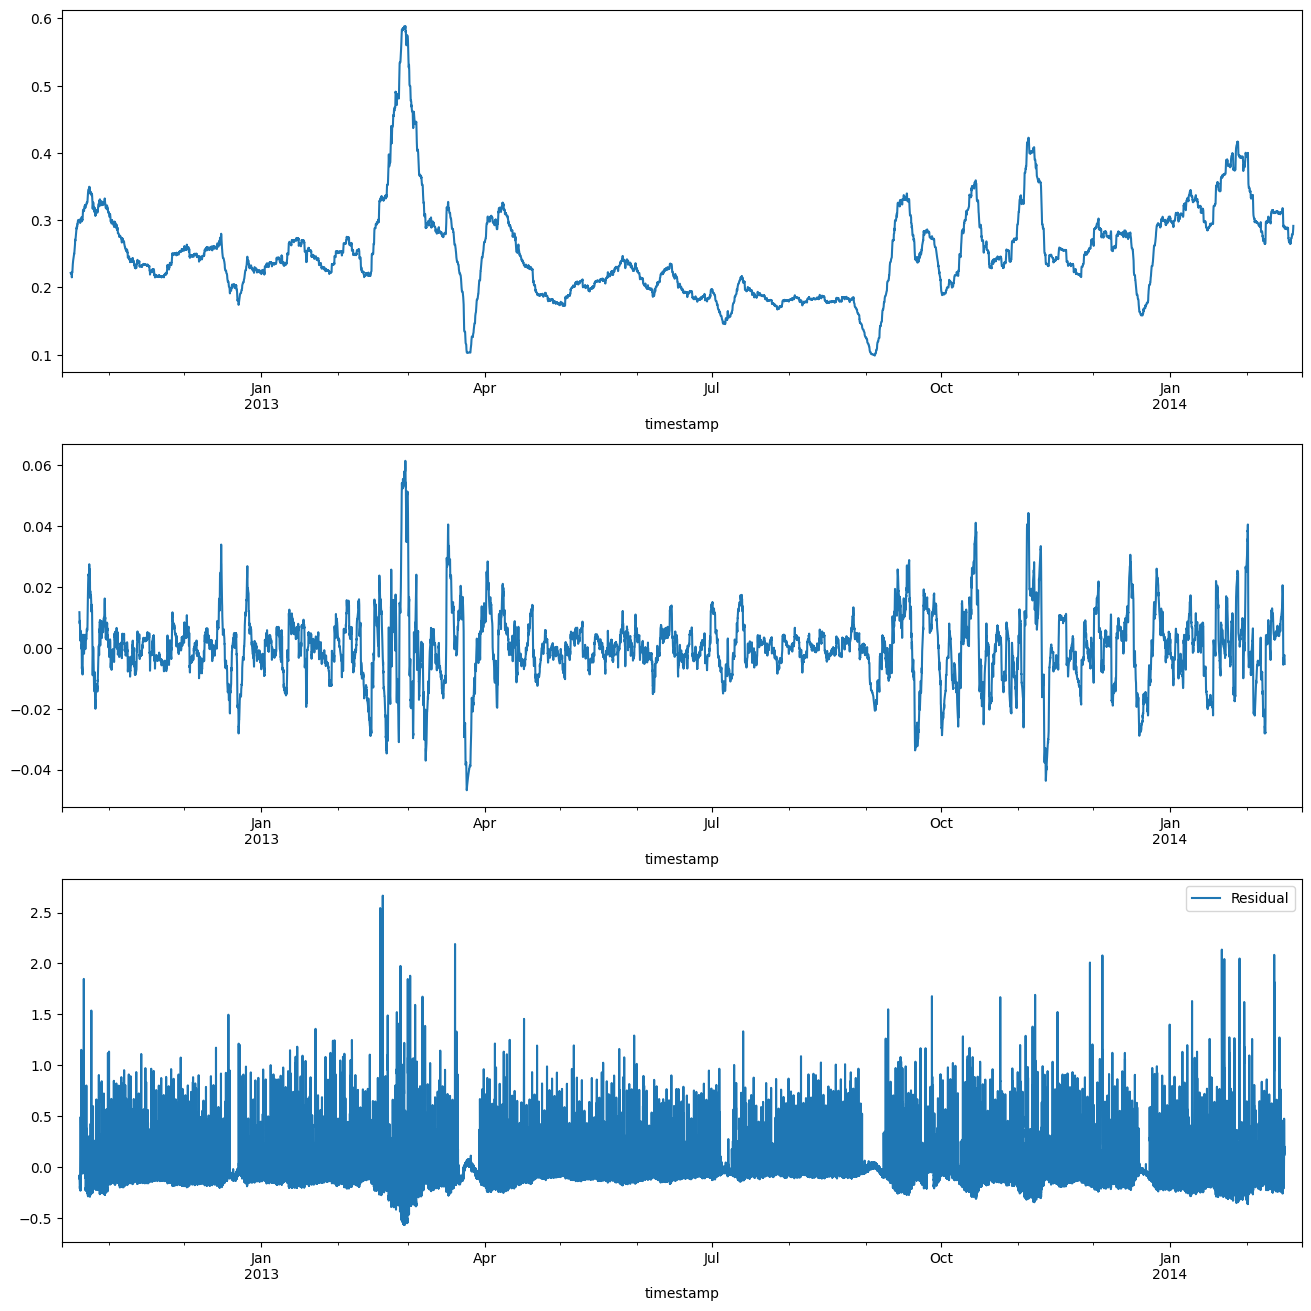

In [60]:
trend = ts_df['energy_consumption'].rolling(window=48*7, center=True).mean()
detrend = ts_df['energy_consumption'] - trend
seasonal = detrend.rolling(window=48*7, center=True).mean()
residual = detrend - seasonal
fig, axs = plt.subplots(3, 1, figsize=(16, 16))
trend.plot(label='Trend', ax=axs[0])
seasonal.plot(label='Seasonal',ax=axs[1])
residual.plot(label='Residual',ax=axs[2])
plt.legend()

### when we used LOESS instead Moving Average to Detrending the trend become more smooth

In [51]:
from statsmodels.nonparametric.smoothers_lowess import lowess

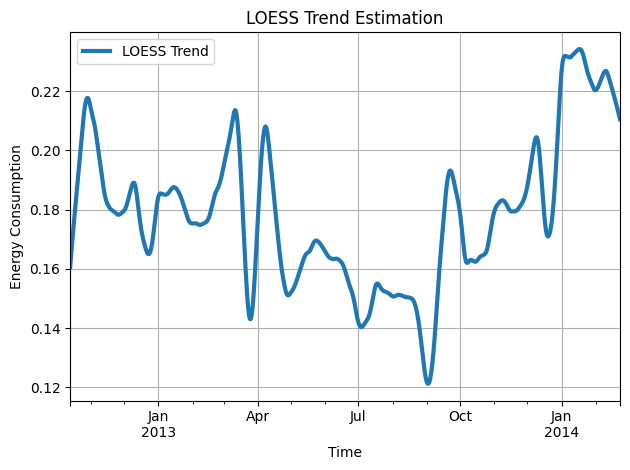

In [52]:
def plot_loess(ts_df, frac=0.05):
  ts_df['lowess_trend'] = lowess(ts_df['energy_consumption'], range(len(ts_df['energy_consumption'])), frac=0.05)[:, 1]
  fig, ax = plt.subplots(1, 1)
  ts_df['lowess_trend'].plot(ax=ax, label='LOESS Trend', linewidth=3)

  ax.set_xlabel('Time')
  ax.set_ylabel('Energy Consumption')
  ax.set_title('LOESS Trend Estimation')
  ax.legend()
  ax.grid(True)
  fig.tight_layout()
  plt.show()

plot_loess(ts_df)


### Basic Seasonal Decomposition (Moving Average + Period Average)

In [53]:
from statsmodels.tsa.seasonal import seasonal_decompose
def plot_normal_seasonal_decomposition(ts_df, column, seasonal_period):

  decomposition = seasonal_decompose(ts_df[column], model='additive', period=seasonal_period)
  trend = decomposition.trend
  seasonal = decomposition.seasonal
  residual = decomposition.resid
  fig, axs = plt.subplots(4, 1, figsize=(16, 16))

  axs[0].plot(ts_df[column], label='Original')
  axs[1].plot(decomposition.trend, label='Trend')
  axs[2].plot(decomposition.seasonal, label='Seasonal')
  axs[3].plot(decomposition.resid, label='Residual')
  for ax in axs:
    ax.legend()
    ax.grid()
  fig.tight_layout()

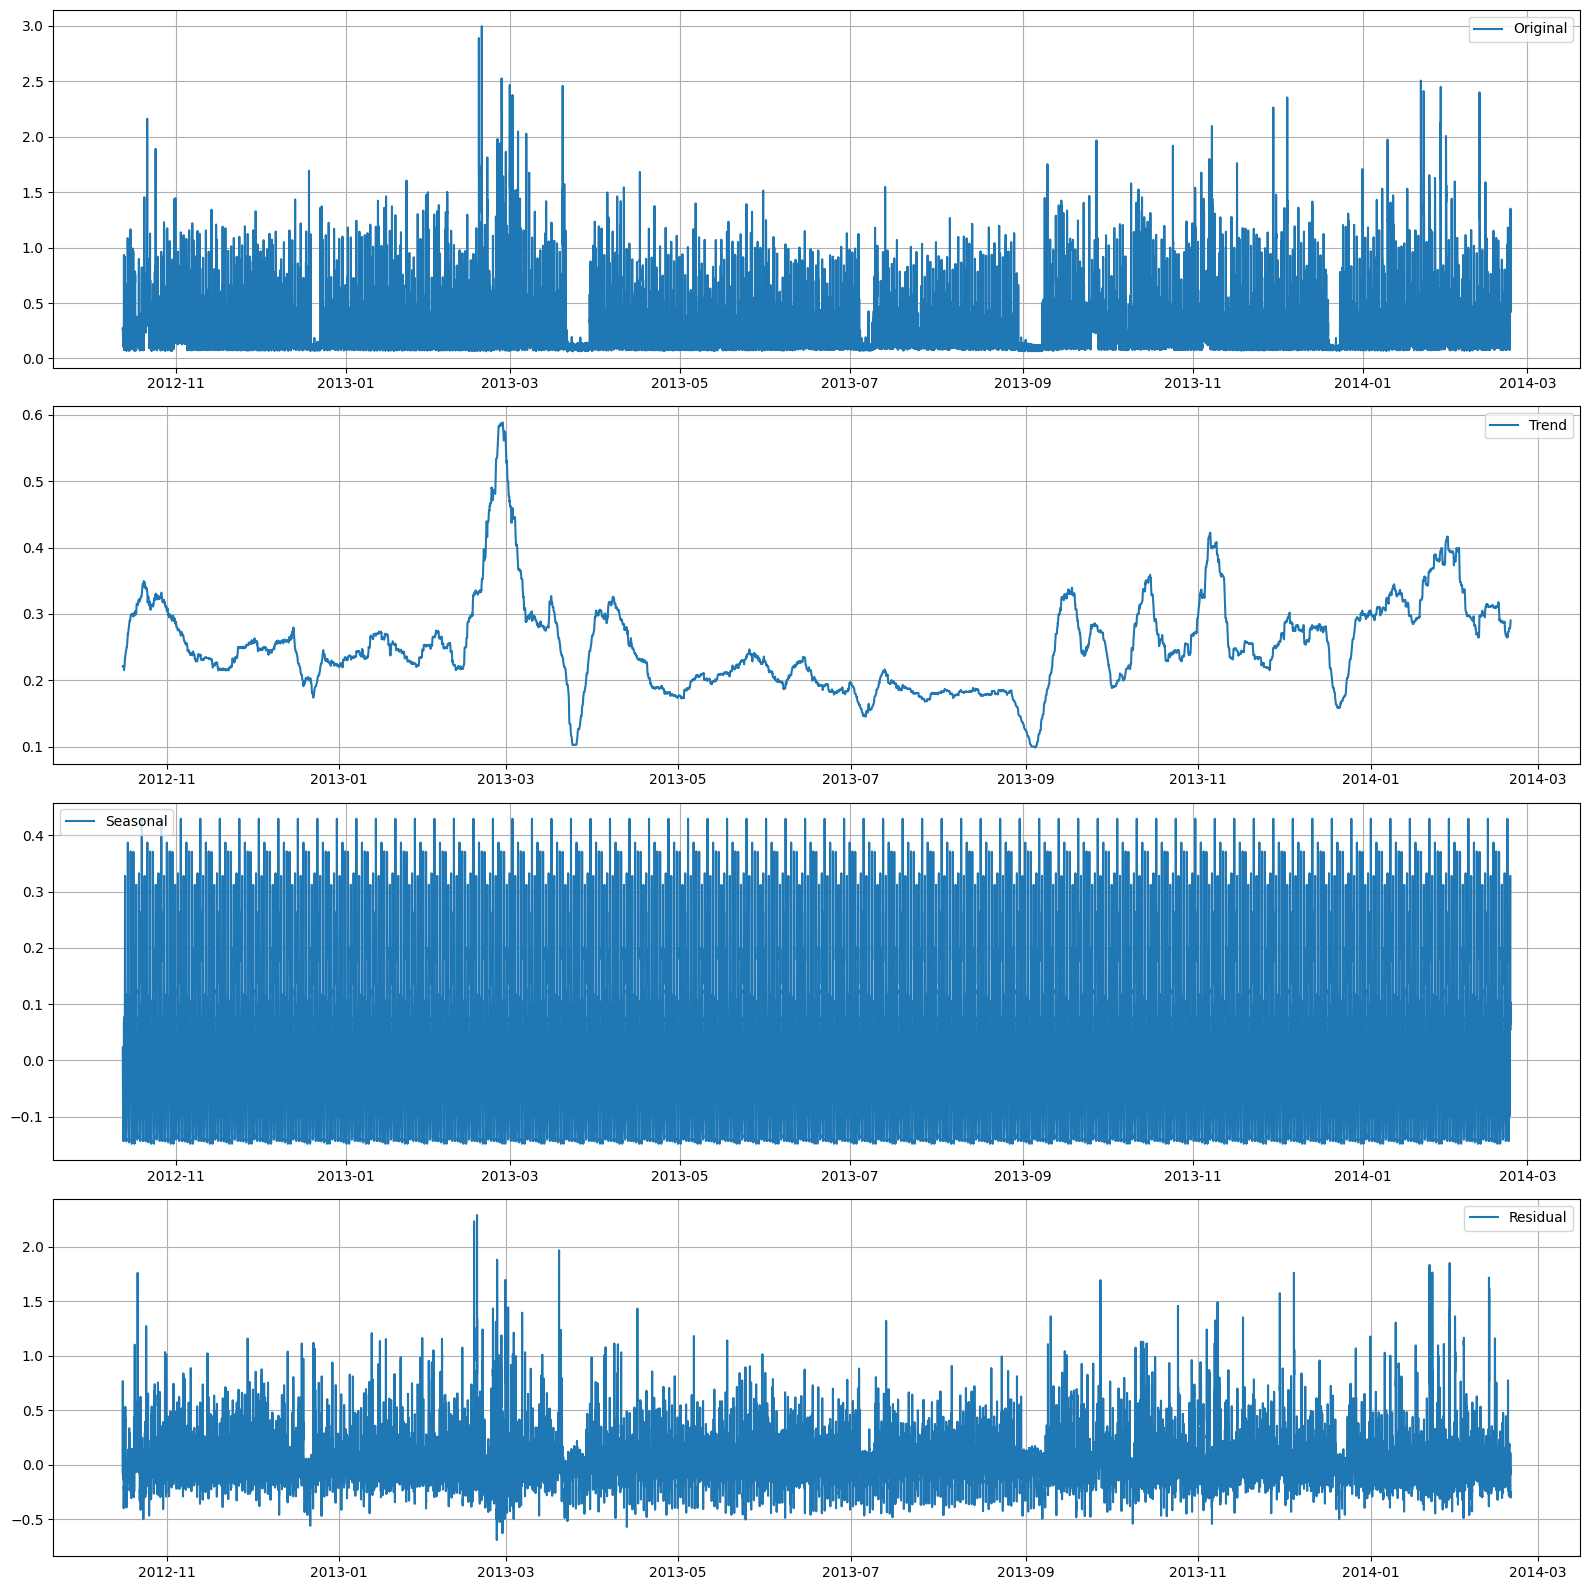

In [54]:
plot_normal_seasonal_decomposition(ts_df, 'energy_consumption', 7*48)

### STL (LOESS + Peroid Averages)

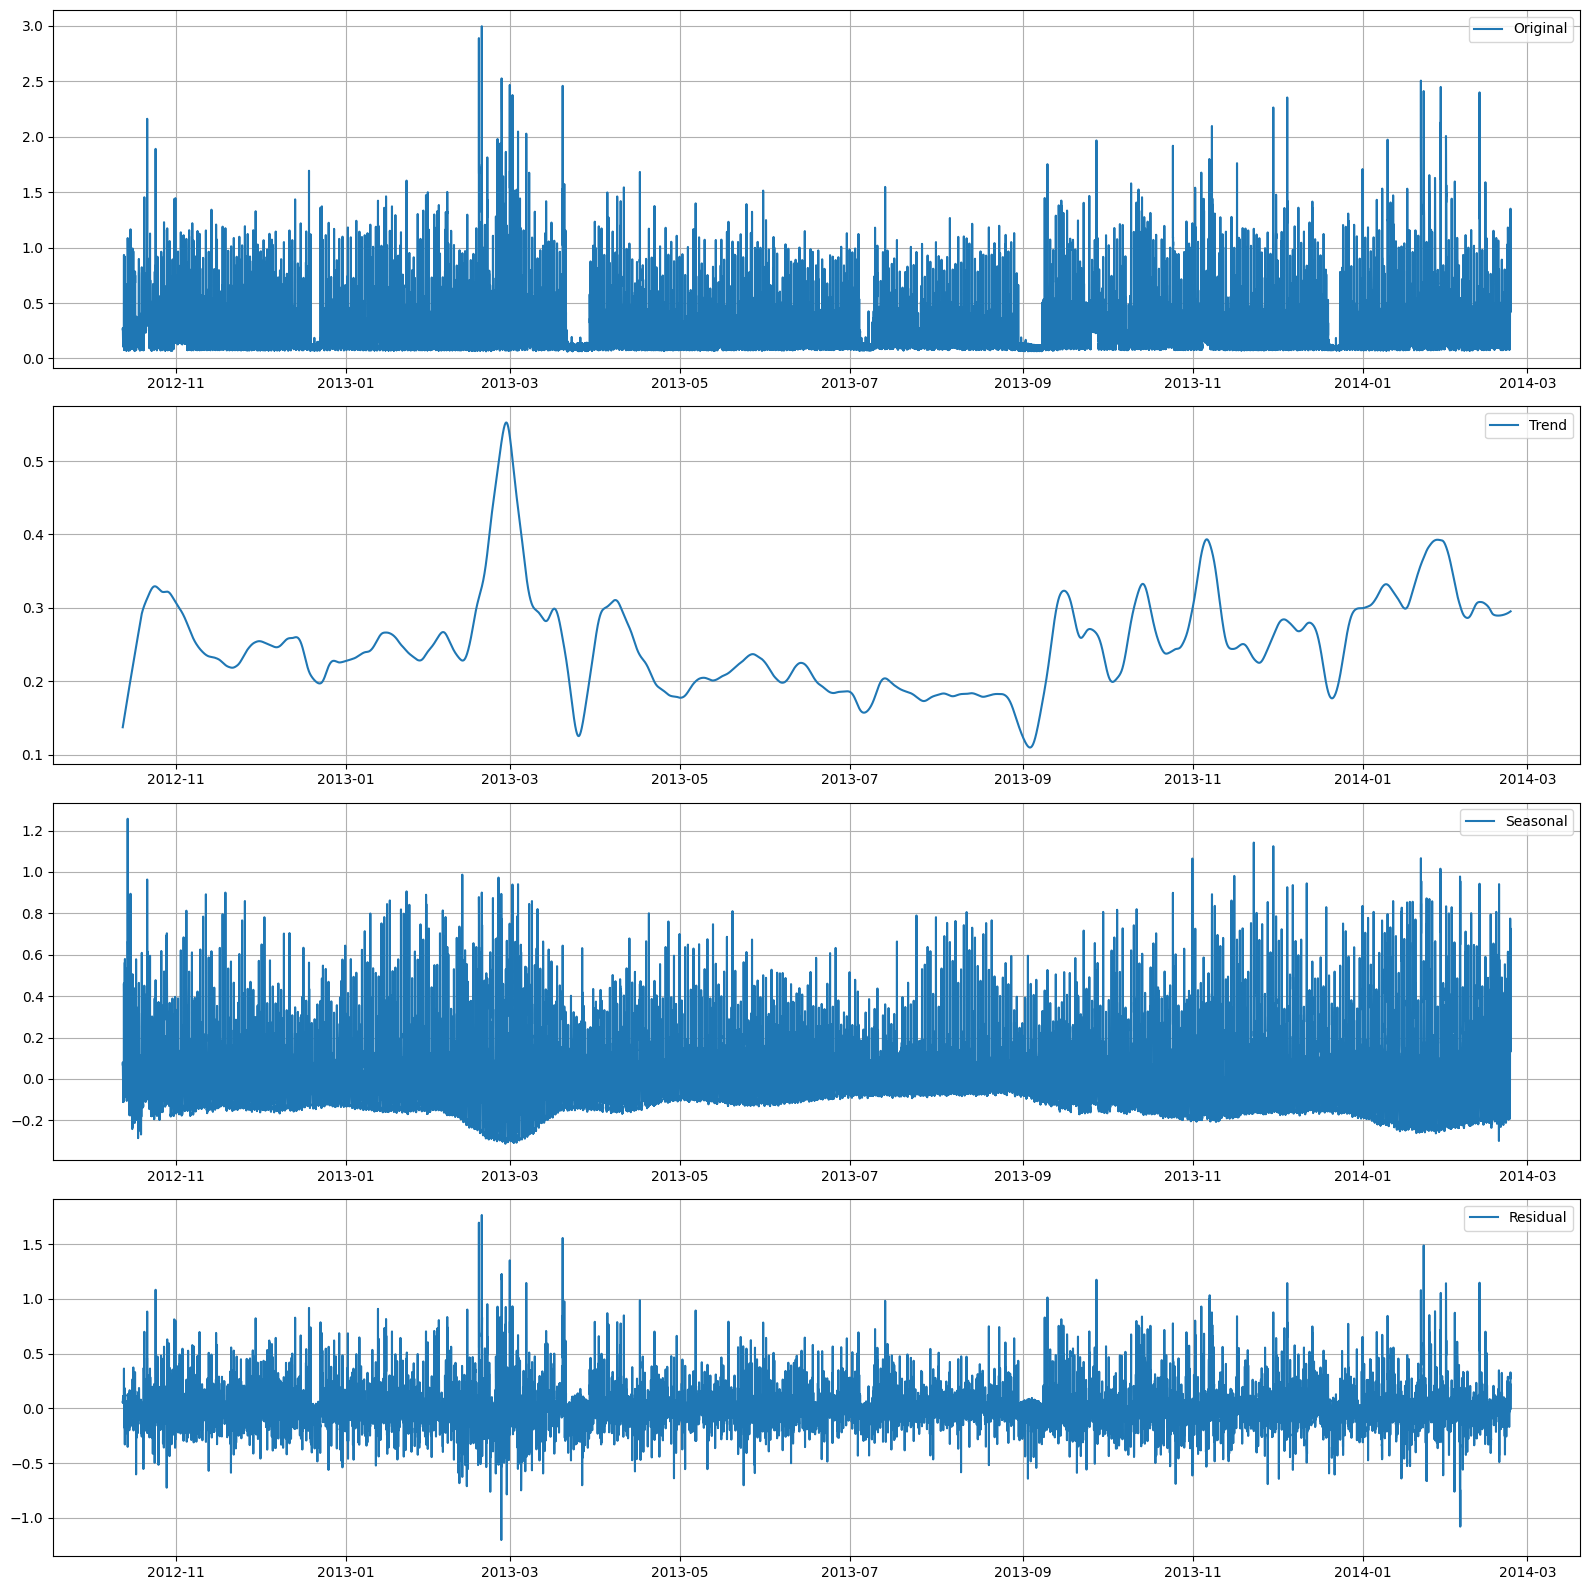

In [55]:
from statsmodels.tsa.seasonal import STL
def plot_stl_decomposition(ts_df, column, period=7*48):
  stl = STL(ts_df[column], period=period)
  res = stl.fit()
  fig, axs = plt.subplots(4, 1, figsize=(16, 16))
  axs[0].plot(ts_df[column], label='Original')
  axs[1].plot(res.trend, label='Trend')
  axs[2].plot(res.seasonal, label='Seasonal')
  axs[3].plot(res.resid, label='Residual')
  for ax in axs:
    ax.legend()
    ax.grid()
  fig.tight_layout()

plot_stl_decomposition(ts_df, 'energy_consumption')


### Fourier Decomposition (LOESS + Fourier Series)

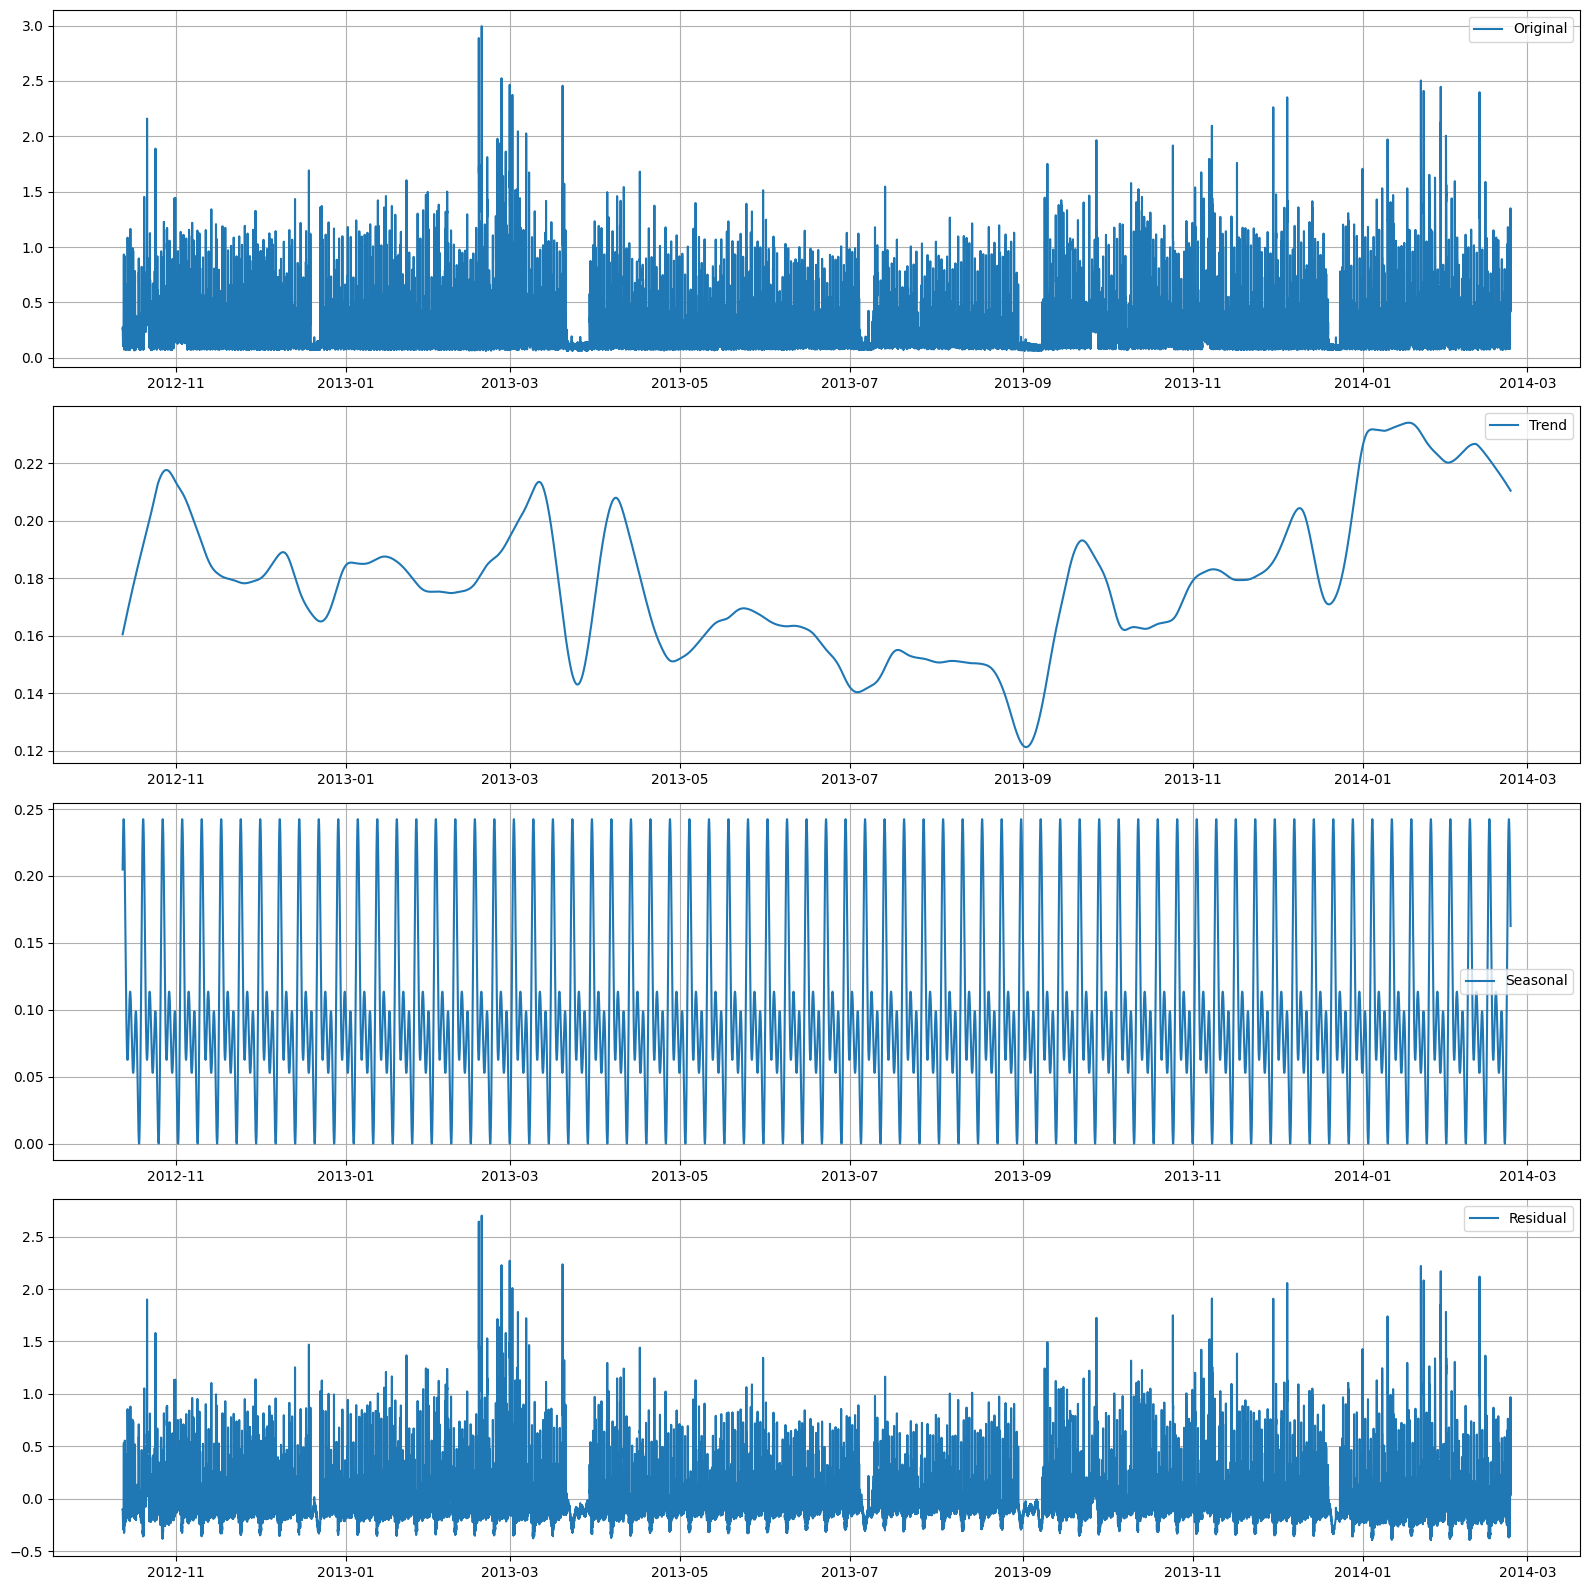

In [56]:
from statsmodels.nonparametric.smoothers_lowess import lowess
import numpy as np

def plot_fourier_decomposition(ts_df,column, seasonal_period, num_harmonics):
    trend = lowess(ts_df[column], range(len(ts_df)), frac=0.05)[:, 1]
    detrended_series = ts_df[column] - trend

    time = np.arange(len(ts_df[column]))
    seasonal = np.zeros_like(ts_df[column])
    for i in range(1, num_harmonics + 1):
        seasonal += (np.sin(2 * np.pi * i * time / seasonal_period) +
                    np.cos(2 * np.pi * i * time / seasonal_period))

    seasonal = (seasonal - seasonal.min()) / (seasonal.max() - seasonal.min())
    seasonal = seasonal * detrended_series.std()

    residual = detrended_series - seasonal
    trend = pd.Series(index=ts_df.index, data=trend)
    seasonal = pd.Series(index=ts_df.index, data=seasonal)
    residual = pd.Series(index=ts_df.index, data=residual)

    fig, axs = plt.subplots(4, 1, figsize=(16, 16))
    axs[0].plot(ts_df[column], label='Original')
    axs[1].plot(trend, label='Trend')
    axs[2].plot(seasonal, label='Seasonal')
    axs[3].plot(residual, label='Residual')
    for ax in axs:
        ax.legend()
        ax.grid()
    fig.tight_layout()

plot_fourier_decomposition(ts_df, 'energy_consumption', 7*48, 3)

## MSTL (Multiple STL for multiple Seasonalities)

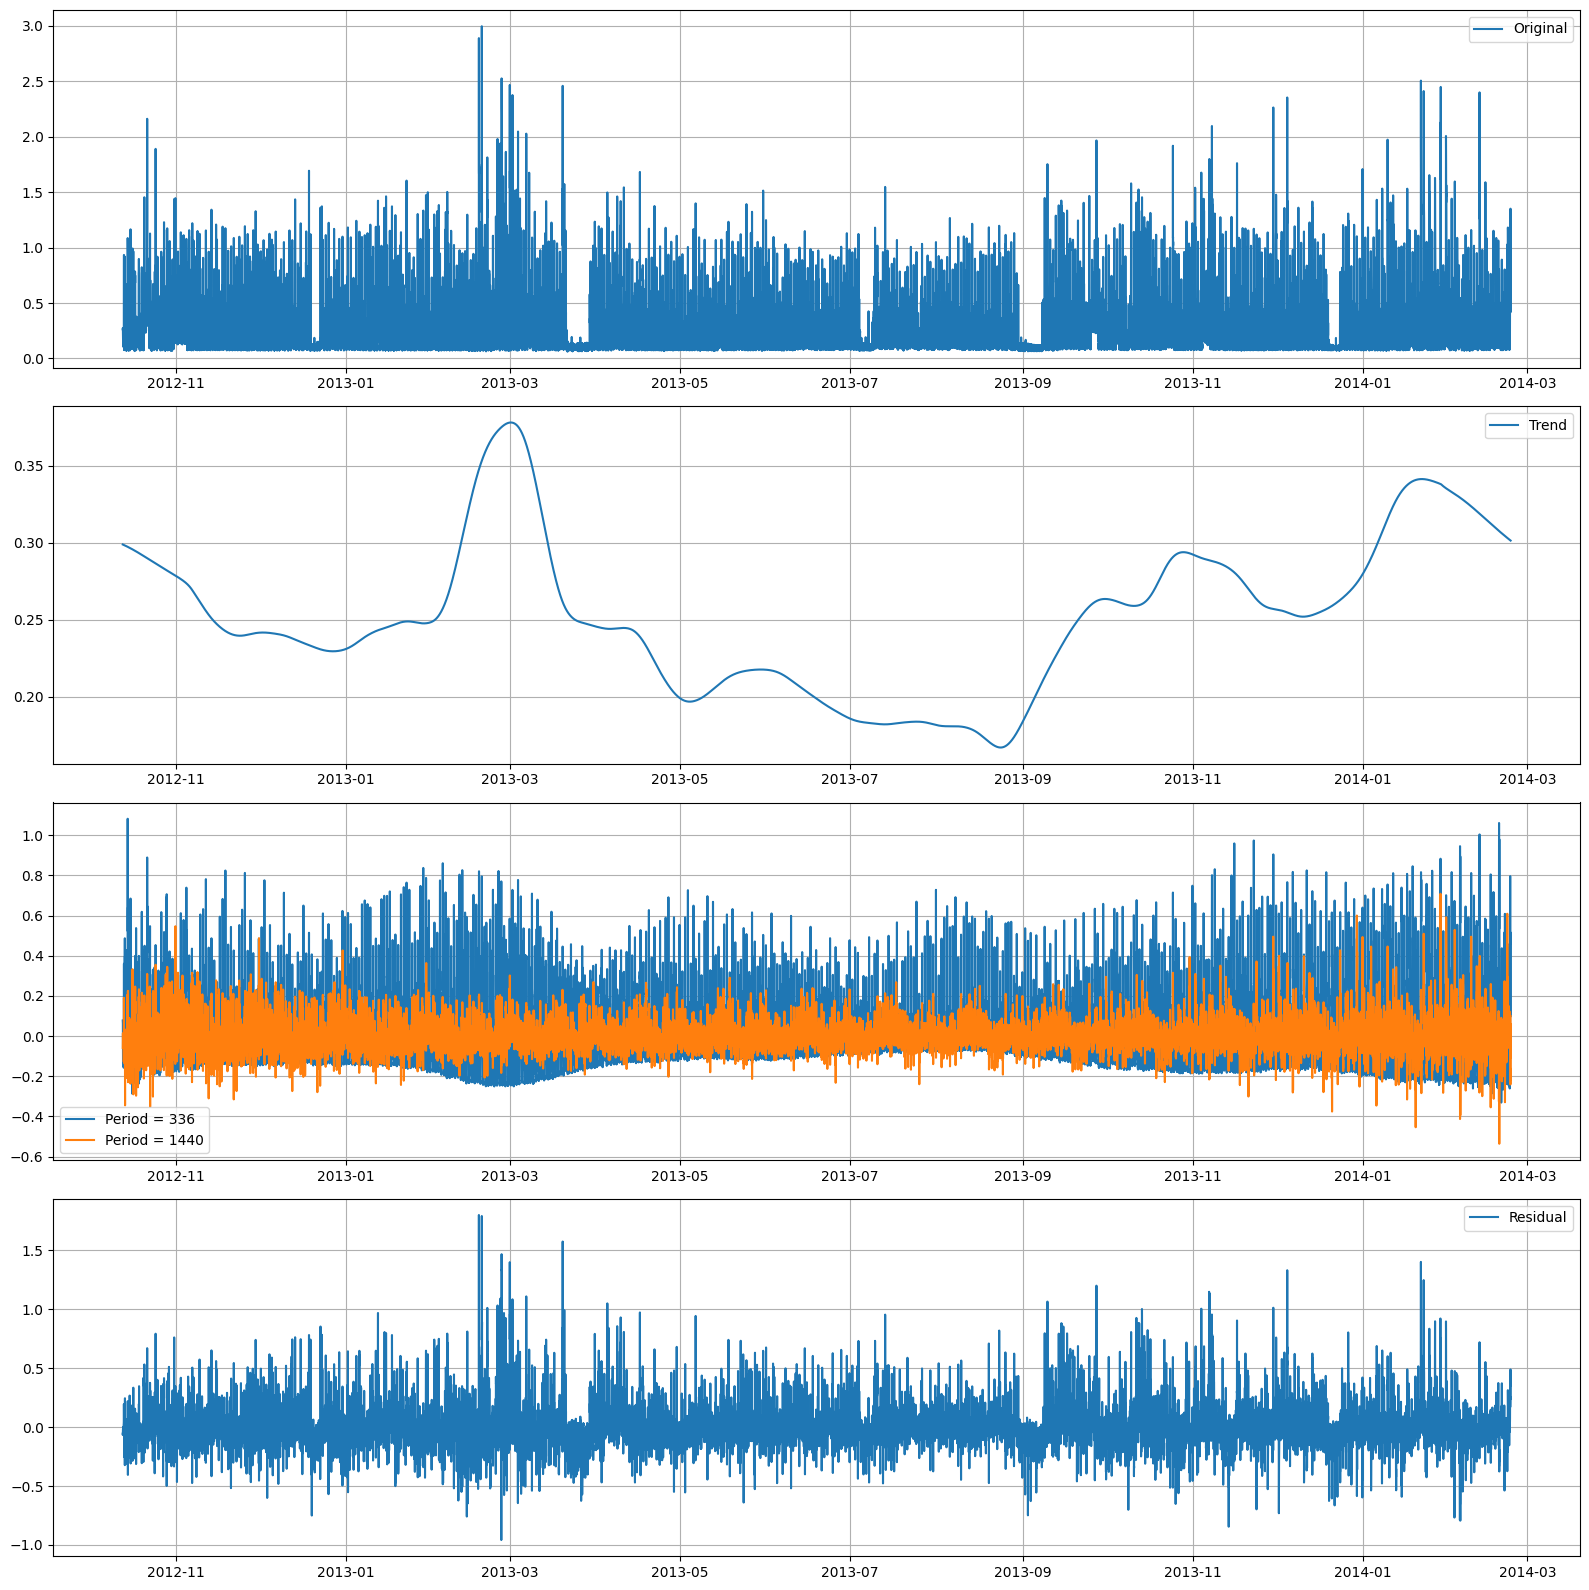

In [57]:
from statsmodels.tsa.seasonal import MSTL
def plot_mstl_decomposition(ts_df, column, periods=[]):
  mstl = MSTL(ts_df[column], periods=periods)
  res = mstl.fit()
  fig, axs = plt.subplots(4, 1, figsize=(16, 16))
  axs[0].plot(ts_df[column], label='Original')
  axs[1].plot(res.trend, label='Trend')
  for i, period in enumerate(periods):
    axs[2].plot(res.seasonal.iloc[:, i], label=f'Period = {period}')
  axs[3].plot(res.resid, label='Residual')
  for ax in axs:
    ax.legend()
    ax.grid()
  fig.tight_layout()

plot_mstl_decomposition(ts_df, 'energy_consumption', periods=[7*48, 30*48])